In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

%matplotlib inline 

In [2]:
train = pd.read_csv('../data/train.csv.zip',nrows = 1e6)
test  = pd.read_csv('../data/test.csv.zip')

In [3]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [4]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [5]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')

In [6]:
#set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
train['is_attributed']=train['is_attributed'].astype('category')

In [7]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000,1693,1000000.0
unique,39611.0,214.0,298.0,160.0,154.0,1731,1530,2.0
top,73487.0,12.0,1.0,19.0,245.0,2017-11-06 16:05:10,2017-11-06 16:14:02,0.0
freq,6437.0,141851.0,938053.0,239642.0,92534.0,1261,4,998307.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-06 16:21:51,2017-11-07 15:55:31,NaN


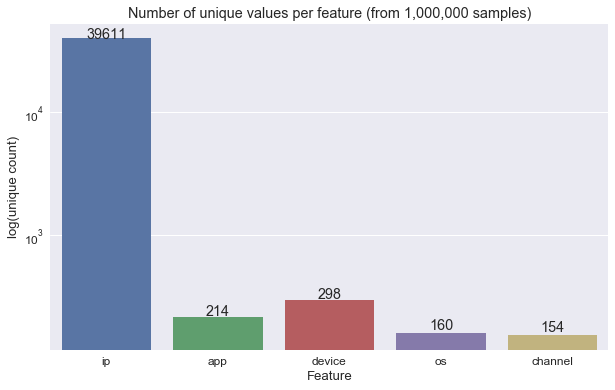

In [8]:
cols = ['ip','app','device','os','channel']
uniques = [len(train[col].unique()) for col in cols]
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 1,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [9]:
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,1693,1693.0
unique,1530,1.0
top,2017-11-06 16:22:12,1.0
freq,4,1693.0
first,2017-11-06 16:00:47,NaN
last,2017-11-07 15:55:31,NaN


In [10]:
#set click_id to categorical, for cleaner statistics view
test['click_id']=test['click_id'].astype('category')
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,18790468.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


In [11]:
train.is_attributed.value_counts() # click only 0.17%  1693 out of 1 million clicks

0    998307
1      1693
Name: is_attributed, dtype: int64

In [12]:
max(train['click_time']).dayofweek ## 0:Monday 

0

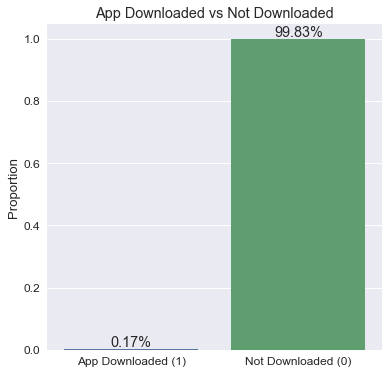

In [13]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [14]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip','counts']
temp.head()

,ip,counts
0,73487,6437
1,73516,6317
2,105560,3474
3,5314,3367
4,5348,3057


In [15]:
#add temporary counts of ip feature ('counts') to the train table, to see if IPs with high counts have conversions
train= train.merge(temp, on='ip', how='left')

In [16]:
train[train.is_attributed==1].sort_values('counts',ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
545495,73487,3,1,13,153,2017-11-06 16:11:02,2017-11-06 16:11:04,1,6437
634686,73487,115,1,17,203,2017-11-06 16:13:05,2017-11-07 04:30:20,1,6437
382519,73487,11,1,13,319,2017-11-06 16:07:24,2017-11-06 16:09:15,1,6437
256256,73487,11,1,19,325,2017-11-06 16:05:02,2017-11-06 16:05:26,1,6437
13481,73487,11,1,17,481,2017-11-06 16:00:18,2017-11-06 16:09:04,1,6437
455924,73516,11,1,19,219,2017-11-06 16:09:00,2017-11-06 16:09:43,1,6317
126416,73516,19,0,50,282,2017-11-06 16:02:19,2017-11-06 16:07:22,1,6317
271395,73516,11,1,13,469,2017-11-06 16:05:16,2017-11-06 16:15:00,1,6317
289189,73516,19,3033,21,213,2017-11-06 16:05:33,2017-11-06 16:05:52,1,6317
450388,105560,20,1,16,478,2017-11-06 16:08:52,2017-11-07 00:37:05,1,3474


In [17]:
train[train['is_attributed']==1].ip.describe()

count      1693
unique     1632
top       73487
freq          5
Name: ip, dtype: int64

In [24]:
#convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(np.uint16)


#### Conversion rates over counts of 300 most popular IPs

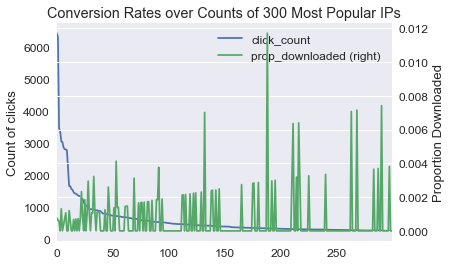

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0    73487         6437         0.000777
1    73516         6317         0.000633
2   105560         3474         0.000576
3     5314         3367         0.000000
4     5348         3057         0.001308
5    53454         3038         0.000000
6   105475         2872         0.000348
7   100275         2815         0.000710
8   201182         2807         0.001069
9   114276         2782         0.000000
10   95766         2242         0.000000
11   45745         1662         0.001203
12  188387         1660         0.000602
13  111025         1573         0.000000
14   86767         1544         0.000000
15  137052         1471         0.000680
16   26995         1433         0.000000
17  209663         1423         0.000703
18  114220         1399         0.000000
19   93054         1368         0.000731


In [40]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

#### Conversion by App

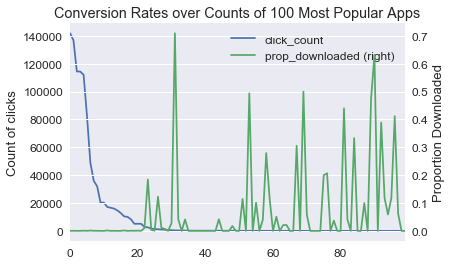

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0   12       141851         0.000134
1    3       136810         0.000446
2   15       114425         0.000210
3    2       114340         0.000262
4    9       112038         0.000848
5   18        82498         0.000376
6    8        48917         0.001288
7   14        35943         0.000473
8    1        32070         0.000343
9    6        20373         0.000098
10  21        20321         0.000148
11  20        17199         0.001628
12  25        16643         0.000120
13  24        16022         0.000374
14  13        14694         0.000068
15  64        12822         0.000312
16  11        10413         0.001633
17  23        10099         0.000000
18  26         8337         0.000720
19  27         5147         0.000389


In [54]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

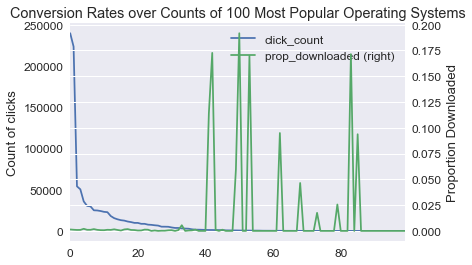

Counversion Rates over Counts of Most Popular Operating Systems
    os  click_count  prop_downloaded
0   19       239642         0.001394
1   13       223440         0.001146
2   17        54055         0.000943
3   18        50421         0.000972
4   22        35751         0.002042
5    8        30340         0.001088
6   10        29754         0.001075
7    6        24998         0.001760
8   25        24795         0.001049
9    9        24116         0.000746
10  15        23133         0.000692
11  20        22742         0.001099
12  16        18013         0.000999
13  14        15484         0.001550
14   3        14073         0.000924
15  37        13023         0.000384
16  41        12508         0.001439
17   1        11393         0.001755
18  12        10695         0.000935
19  35         9731         0.000822


In [55]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

In [56]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge)

Count of clicks and proportion of downloads by device:
    device  click_count  prop_downloaded
0        1       938053         0.001193
1        2        49330         0.000182
2     3032         8167         0.000000
3        0         3183         0.114986
4       59          254         0.000000
5        6           55         0.163636
6       40           46         0.260870
7       18           42         0.142857
8       37           30         0.166667
9       73           24         0.125000
10      33           23         0.173913
11      16           23         0.130435
12      88           18         0.388889
13      21           18         0.277778
14       7           17         0.411765
15      78           16         0.187500
16     109           14         0.142857
17     231           12         0.166667
18     395           12         0.000000
19     114           12         0.083333
20    3033           12         0.416667
21      67           11         0.272727
22

In [61]:
train.app.unique()

[3, 14, 64, 18, 6, ..., 551, 549, 59, 372, 76]
Length: 214
Categories (214, int64): [3, 14, 64, 18, ..., 549, 59, 372, 76]